In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import glob
import scipy
import csv
from PIL import Image

from keras import backend as K
from keras.models import Model
from keras.layers import Input, Layer

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("."))

# Any results you write to the current directory are saved as output.

['train.csv', 'test.zip', 'kernel7631789da2.ipynb', 'train.zip', 'sample_submission.csv', 'train', 'test', '.ipynb_checkpoints']


In [4]:
# -----------------------------------------------------------------------------------------
# Code taken from https://github.com/iwantooxxoox/Keras-OpenFace (with minor modifications)
# -----------------------------------------------------------------------------------------

import tensorflow as tf
import numpy as np
import os

from numpy import genfromtxt
from keras.layers import Conv2D, ZeroPadding2D, Activation
from keras.layers.normalization import BatchNormalization

_FLOATX = 'float32'

def variable(value, dtype=_FLOATX, name=None):
  v = tf.Variable(np.asarray(value, dtype=dtype), name=name)
  _get_session().run(v.initializer)
  return v

def shape(x):
  return x.get_shape()

def square(x):
  return tf.square(x)

def zeros(shape, dtype=_FLOATX, name=None):
  return variable(np.zeros(shape), dtype, name)

def concatenate(tensors, axis=-1):
  if axis < 0:
      axis = axis % len(tensors[0].get_shape())
  return tf.concat(axis, tensors)

def LRN2D(x):
  return tf.nn.lrn(x, alpha=1e-4, beta=0.75)

def conv2d_bn(
  x,
  layer=None,
  cv1_out=None,
  cv1_filter=(1, 1),
  cv1_strides=(1, 1),
  cv2_out=None,
  cv2_filter=(3, 3),
  cv2_strides=(1, 1),
  padding=None,
):
  num = '' if cv2_out == None else '1'
  tensor = Conv2D(cv1_out, cv1_filter, strides=cv1_strides, name=layer+'_conv'+num)(x)
  tensor = BatchNormalization(axis=3, epsilon=0.00001, name=layer+'_bn'+num)(tensor)
  tensor = Activation('relu')(tensor)
  if padding == None:
    return tensor
  tensor = ZeroPadding2D(padding=padding)(tensor)
  if cv2_out == None:
    return tensor
  tensor = Conv2D(cv2_out, cv2_filter, strides=cv2_strides, name=layer+'_conv'+'2')(tensor)
  tensor = BatchNormalization(axis=3, epsilon=0.00001, name=layer+'_bn'+'2')(tensor)
  tensor = Activation('relu')(tensor)
  return tensor

weights = [
  'conv1', 'bn1', 'conv2', 'bn2', 'conv3', 'bn3',
  'inception_3a_1x1_conv', 'inception_3a_1x1_bn',
  'inception_3a_pool_conv', 'inception_3a_pool_bn',
  'inception_3a_5x5_conv1', 'inception_3a_5x5_conv2', 'inception_3a_5x5_bn1', 'inception_3a_5x5_bn2',
  'inception_3a_3x3_conv1', 'inception_3a_3x3_conv2', 'inception_3a_3x3_bn1', 'inception_3a_3x3_bn2',
  'inception_3b_3x3_conv1', 'inception_3b_3x3_conv2', 'inception_3b_3x3_bn1', 'inception_3b_3x3_bn2',
  'inception_3b_5x5_conv1', 'inception_3b_5x5_conv2', 'inception_3b_5x5_bn1', 'inception_3b_5x5_bn2',
  'inception_3b_pool_conv', 'inception_3b_pool_bn',
  'inception_3b_1x1_conv', 'inception_3b_1x1_bn',
  'inception_3c_3x3_conv1', 'inception_3c_3x3_conv2', 'inception_3c_3x3_bn1', 'inception_3c_3x3_bn2',
  'inception_3c_5x5_conv1', 'inception_3c_5x5_conv2', 'inception_3c_5x5_bn1', 'inception_3c_5x5_bn2',
  'inception_4a_3x3_conv1', 'inception_4a_3x3_conv2', 'inception_4a_3x3_bn1', 'inception_4a_3x3_bn2',
  'inception_4a_5x5_conv1', 'inception_4a_5x5_conv2', 'inception_4a_5x5_bn1', 'inception_4a_5x5_bn2',
  'inception_4a_pool_conv', 'inception_4a_pool_bn',
  'inception_4a_1x1_conv', 'inception_4a_1x1_bn',
  'inception_4e_3x3_conv1', 'inception_4e_3x3_conv2', 'inception_4e_3x3_bn1', 'inception_4e_3x3_bn2',
  'inception_4e_5x5_conv1', 'inception_4e_5x5_conv2', 'inception_4e_5x5_bn1', 'inception_4e_5x5_bn2',
  'inception_5a_3x3_conv1', 'inception_5a_3x3_conv2', 'inception_5a_3x3_bn1', 'inception_5a_3x3_bn2',
  'inception_5a_pool_conv', 'inception_5a_pool_bn',
  'inception_5a_1x1_conv', 'inception_5a_1x1_bn',
  'inception_5b_3x3_conv1', 'inception_5b_3x3_conv2', 'inception_5b_3x3_bn1', 'inception_5b_3x3_bn2',
  'inception_5b_pool_conv', 'inception_5b_pool_bn',
  'inception_5b_1x1_conv', 'inception_5b_1x1_bn',
  'dense_layer'
]

conv_shape = {
  'conv1': [64, 3, 7, 7],
  'conv2': [64, 64, 1, 1],
  'conv3': [192, 64, 3, 3],
  'inception_3a_1x1_conv': [64, 192, 1, 1],
  'inception_3a_pool_conv': [32, 192, 1, 1],
  'inception_3a_5x5_conv1': [16, 192, 1, 1],
  'inception_3a_5x5_conv2': [32, 16, 5, 5],
  'inception_3a_3x3_conv1': [96, 192, 1, 1],
  'inception_3a_3x3_conv2': [128, 96, 3, 3],
  'inception_3b_3x3_conv1': [96, 256, 1, 1],
  'inception_3b_3x3_conv2': [128, 96, 3, 3],
  'inception_3b_5x5_conv1': [32, 256, 1, 1],
  'inception_3b_5x5_conv2': [64, 32, 5, 5],
  'inception_3b_pool_conv': [64, 256, 1, 1],
  'inception_3b_1x1_conv': [64, 256, 1, 1],
  'inception_3c_3x3_conv1': [128, 320, 1, 1],
  'inception_3c_3x3_conv2': [256, 128, 3, 3],
  'inception_3c_5x5_conv1': [32, 320, 1, 1],
  'inception_3c_5x5_conv2': [64, 32, 5, 5],
  'inception_4a_3x3_conv1': [96, 640, 1, 1],
  'inception_4a_3x3_conv2': [192, 96, 3, 3],
  'inception_4a_5x5_conv1': [32, 640, 1, 1,],
  'inception_4a_5x5_conv2': [64, 32, 5, 5],
  'inception_4a_pool_conv': [128, 640, 1, 1],
  'inception_4a_1x1_conv': [256, 640, 1, 1],
  'inception_4e_3x3_conv1': [160, 640, 1, 1],
  'inception_4e_3x3_conv2': [256, 160, 3, 3],
  'inception_4e_5x5_conv1': [64, 640, 1, 1],
  'inception_4e_5x5_conv2': [128, 64, 5, 5],
  'inception_5a_3x3_conv1': [96, 1024, 1, 1],
  'inception_5a_3x3_conv2': [384, 96, 3, 3],
  'inception_5a_pool_conv': [96, 1024, 1, 1],
  'inception_5a_1x1_conv': [256, 1024, 1, 1],
  'inception_5b_3x3_conv1': [96, 736, 1, 1],
  'inception_5b_3x3_conv2': [384, 96, 3, 3],
  'inception_5b_pool_conv': [96, 736, 1, 1],
  'inception_5b_1x1_conv': [256, 736, 1, 1],
}

def load_weights():
  weightsDir = './weights'
  fileNames = filter(lambda f: not f.startswith('.'), os.listdir(weightsDir))
  paths = {}
  weights_dict = {}

  for n in fileNames:
    paths[n.replace('.csv', '')] = weightsDir + '/' + n

  for name in weights:
    if 'conv' in name:
      conv_w = genfromtxt(paths[name + '_w'], delimiter=',', dtype=None)
      conv_w = np.reshape(conv_w, conv_shape[name])
      conv_w = np.transpose(conv_w, (2, 3, 1, 0))
      conv_b = genfromtxt(paths[name + '_b'], delimiter=',', dtype=None)
      weights_dict[name] = [conv_w, conv_b]     
    elif 'bn' in name:
      bn_w = genfromtxt(paths[name + '_w'], delimiter=',', dtype=None)
      bn_b = genfromtxt(paths[name + '_b'], delimiter=',', dtype=None)
      bn_m = genfromtxt(paths[name + '_m'], delimiter=',', dtype=None)
      bn_v = genfromtxt(paths[name + '_v'], delimiter=',', dtype=None)
      weights_dict[name] = [bn_w, bn_b, bn_m, bn_v]
    elif 'dense' in name:
      dense_w = genfromtxt(weightsDir+'/dense_w.csv', delimiter=',', dtype=None)
      dense_w = np.reshape(dense_w, (128, 736))
      dense_w = np.transpose(dense_w, (1, 0))
      dense_b = genfromtxt(weightsDir+'/dense_b.csv', delimiter=',', dtype=None)
      weights_dict[name] = [dense_w, dense_b]

  return weights_dict

In [5]:
# -----------------------------------------------------------------------------------------
# Code taken from https://github.com/iwantooxxoox/Keras-OpenFace (with minor modifications)
# -----------------------------------------------------------------------------------------

from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.models import Model
from keras import backend as K

def create_model(input_shape):
    myInput = Input(shape=input_shape)

    x = ZeroPadding2D(padding=(3, 3), input_shape=input_shape)(myInput)
    x = Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(x)
    x = BatchNormalization(axis=3, epsilon=0.00001, name='bn1')(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D(padding=(1, 1))(x)
    x = MaxPooling2D(pool_size=3, strides=2)(x)
    x = Lambda(LRN2D, name='lrn_1')(x)
    x = Conv2D(64, (1, 1), name='conv2')(x)
    x = BatchNormalization(axis=3, epsilon=0.00001, name='bn2')(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D(padding=(1, 1))(x)
    x = Conv2D(192, (3, 3), name='conv3')(x)
    x = BatchNormalization(axis=3, epsilon=0.00001, name='bn3')(x)
    x = Activation('relu')(x)
    x = Lambda(LRN2D, name='lrn_2')(x)
    x = ZeroPadding2D(padding=(1, 1))(x)
    x = MaxPooling2D(pool_size=3, strides=2)(x)

    # Inception3a
    inception_3a_3x3 = Conv2D(96, (1, 1), name='inception_3a_3x3_conv1')(x)
    inception_3a_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_3x3_bn1')(inception_3a_3x3)
    inception_3a_3x3 = Activation('relu')(inception_3a_3x3)
    inception_3a_3x3 = ZeroPadding2D(padding=(1, 1))(inception_3a_3x3)
    inception_3a_3x3 = Conv2D(128, (3, 3), name='inception_3a_3x3_conv2')(inception_3a_3x3)
    inception_3a_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_3x3_bn2')(inception_3a_3x3)
    inception_3a_3x3 = Activation('relu')(inception_3a_3x3)

    inception_3a_5x5 = Conv2D(16, (1, 1), name='inception_3a_5x5_conv1')(x)
    inception_3a_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_5x5_bn1')(inception_3a_5x5)
    inception_3a_5x5 = Activation('relu')(inception_3a_5x5)
    inception_3a_5x5 = ZeroPadding2D(padding=(2, 2))(inception_3a_5x5)
    inception_3a_5x5 = Conv2D(32, (5, 5), name='inception_3a_5x5_conv2')(inception_3a_5x5)
    inception_3a_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_5x5_bn2')(inception_3a_5x5)
    inception_3a_5x5 = Activation('relu')(inception_3a_5x5)

    inception_3a_pool = MaxPooling2D(pool_size=3, strides=2)(x)
    inception_3a_pool = Conv2D(32, (1, 1), name='inception_3a_pool_conv')(inception_3a_pool)
    inception_3a_pool = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_pool_bn')(inception_3a_pool)
    inception_3a_pool = Activation('relu')(inception_3a_pool)
    inception_3a_pool = ZeroPadding2D(padding=((3, 4), (3, 4)))(inception_3a_pool)

    inception_3a_1x1 = Conv2D(64, (1, 1), name='inception_3a_1x1_conv')(x)
    inception_3a_1x1 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_1x1_bn')(inception_3a_1x1)
    inception_3a_1x1 = Activation('relu')(inception_3a_1x1)

    inception_3a = concatenate([inception_3a_3x3, inception_3a_5x5, inception_3a_pool, inception_3a_1x1], axis=3)

    # Inception3b
    inception_3b_3x3 = Conv2D(96, (1, 1), name='inception_3b_3x3_conv1')(inception_3a)
    inception_3b_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_3x3_bn1')(inception_3b_3x3)
    inception_3b_3x3 = Activation('relu')(inception_3b_3x3)
    inception_3b_3x3 = ZeroPadding2D(padding=(1, 1))(inception_3b_3x3)
    inception_3b_3x3 = Conv2D(128, (3, 3), name='inception_3b_3x3_conv2')(inception_3b_3x3)
    inception_3b_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_3x3_bn2')(inception_3b_3x3)
    inception_3b_3x3 = Activation('relu')(inception_3b_3x3)

    inception_3b_5x5 = Conv2D(32, (1, 1), name='inception_3b_5x5_conv1')(inception_3a)
    inception_3b_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_5x5_bn1')(inception_3b_5x5)
    inception_3b_5x5 = Activation('relu')(inception_3b_5x5)
    inception_3b_5x5 = ZeroPadding2D(padding=(2, 2))(inception_3b_5x5)
    inception_3b_5x5 = Conv2D(64, (5, 5), name='inception_3b_5x5_conv2')(inception_3b_5x5)
    inception_3b_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_5x5_bn2')(inception_3b_5x5)
    inception_3b_5x5 = Activation('relu')(inception_3b_5x5)

    inception_3b_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3))(inception_3a)
    inception_3b_pool = Conv2D(64, (1, 1), name='inception_3b_pool_conv')(inception_3b_pool)
    inception_3b_pool = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_pool_bn')(inception_3b_pool)
    inception_3b_pool = Activation('relu')(inception_3b_pool)
    inception_3b_pool = ZeroPadding2D(padding=(4, 4))(inception_3b_pool)

    inception_3b_1x1 = Conv2D(64, (1, 1), name='inception_3b_1x1_conv')(inception_3a)
    inception_3b_1x1 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_1x1_bn')(inception_3b_1x1)
    inception_3b_1x1 = Activation('relu')(inception_3b_1x1)

    inception_3b = concatenate([inception_3b_3x3, inception_3b_5x5, inception_3b_pool, inception_3b_1x1], axis=3)

    # Inception3c
    inception_3c_3x3 = conv2d_bn(inception_3b,
                                       layer='inception_3c_3x3',
                                       cv1_out=128,
                                       cv1_filter=(1, 1),
                                       cv2_out=256,
                                       cv2_filter=(3, 3),
                                       cv2_strides=(2, 2),
                                       padding=(1, 1))

    inception_3c_5x5 = conv2d_bn(inception_3b,
                                       layer='inception_3c_5x5',
                                       cv1_out=32,
                                       cv1_filter=(1, 1),
                                       cv2_out=64,
                                       cv2_filter=(5, 5),
                                       cv2_strides=(2, 2),
                                       padding=(2, 2))

    inception_3c_pool = MaxPooling2D(pool_size=3, strides=2)(inception_3b)
    inception_3c_pool = ZeroPadding2D(padding=((0, 1), (0, 1)))(inception_3c_pool)

    inception_3c = concatenate([inception_3c_3x3, inception_3c_5x5, inception_3c_pool], axis=3)

    #inception 4a
    inception_4a_3x3 = conv2d_bn(inception_3c,
                                       layer='inception_4a_3x3',
                                       cv1_out=96,
                                       cv1_filter=(1, 1),
                                       cv2_out=192,
                                       cv2_filter=(3, 3),
                                       cv2_strides=(1, 1),
                                       padding=(1, 1))
    inception_4a_5x5 = conv2d_bn(inception_3c,
                                       layer='inception_4a_5x5',
                                       cv1_out=32,
                                       cv1_filter=(1, 1),
                                       cv2_out=64,
                                       cv2_filter=(5, 5),
                                       cv2_strides=(1, 1),
                                       padding=(2, 2))

    inception_4a_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3))(inception_3c)
    inception_4a_pool = conv2d_bn(inception_4a_pool,
                                        layer='inception_4a_pool',
                                        cv1_out=128,
                                        cv1_filter=(1, 1),
                                        padding=(2, 2))
    inception_4a_1x1 = conv2d_bn(inception_3c,
                                       layer='inception_4a_1x1',
                                       cv1_out=256,
                                       cv1_filter=(1, 1))
    inception_4a = concatenate([inception_4a_3x3, inception_4a_5x5, inception_4a_pool, inception_4a_1x1], axis=3)

    #inception4e
    inception_4e_3x3 = conv2d_bn(inception_4a,
                                       layer='inception_4e_3x3',
                                       cv1_out=160,
                                       cv1_filter=(1, 1),
                                       cv2_out=256,
                                       cv2_filter=(3, 3),
                                       cv2_strides=(2, 2),
                                       padding=(1, 1))
    inception_4e_5x5 = conv2d_bn(inception_4a,
                                       layer='inception_4e_5x5',
                                       cv1_out=64,
                                       cv1_filter=(1, 1),
                                       cv2_out=128,
                                       cv2_filter=(5, 5),
                                       cv2_strides=(2, 2),
                                       padding=(2, 2))
    inception_4e_pool = MaxPooling2D(pool_size=3, strides=2)(inception_4a)
    inception_4e_pool = ZeroPadding2D(padding=((0, 1), (0, 1)))(inception_4e_pool)

    inception_4e = concatenate([inception_4e_3x3, inception_4e_5x5, inception_4e_pool], axis=3)

    #inception5a
    inception_5a_3x3 = conv2d_bn(inception_4e,
                                       layer='inception_5a_3x3',
                                       cv1_out=96,
                                       cv1_filter=(1, 1),
                                       cv2_out=384,
                                       cv2_filter=(3, 3),
                                       cv2_strides=(1, 1),
                                       padding=(1, 1))

    inception_5a_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3))(inception_4e)
    inception_5a_pool = conv2d_bn(inception_5a_pool,
                                        layer='inception_5a_pool',
                                        cv1_out=96,
                                        cv1_filter=(1, 1),
                                        padding=(1, 1))
    inception_5a_1x1 = conv2d_bn(inception_4e,
                                       layer='inception_5a_1x1',
                                       cv1_out=256,
                                       cv1_filter=(1, 1))

    inception_5a = concatenate([inception_5a_3x3, inception_5a_pool, inception_5a_1x1], axis=3)

    #inception_5b
    inception_5b_3x3 = conv2d_bn(inception_5a,
                                       layer='inception_5b_3x3',
                                       cv1_out=96,
                                       cv1_filter=(1, 1),
                                       cv2_out=384,
                                       cv2_filter=(3, 3),
                                       cv2_strides=(1, 1),
                                       padding=(1, 1))
    inception_5b_pool = MaxPooling2D(pool_size=3, strides=2)(inception_5a)
    inception_5b_pool = conv2d_bn(inception_5b_pool,
                                        layer='inception_5b_pool',
                                        cv1_out=96,
                                        cv1_filter=(1, 1))
    inception_5b_pool = ZeroPadding2D(padding=(1, 1))(inception_5b_pool)

    inception_5b_1x1 = conv2d_bn(inception_5a,
                                       layer='inception_5b_1x1',
                                       cv1_out=256,
                                       cv1_filter=(1, 1))
    inception_5b = concatenate([inception_5b_3x3, inception_5b_pool, inception_5b_1x1], axis=3)

    av_pool = AveragePooling2D(pool_size=(3, 3), strides=(1, 1))(inception_5b)
    reshape_layer = Flatten()(av_pool)
    dense_layer = Dense(128, name='dense_layer')(reshape_layer)
    norm_layer = Lambda(lambda  x: K.l2_normalize(x, axis=1), name='norm_layer')(dense_layer)

    return Model(inputs=[myInput], outputs=norm_layer)

In [6]:
input_shape = (96, 96, 3)
nn4_small2 = create_model(input_shape)
nn4_small2.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 102, 102, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 48, 48, 64)   9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn1 (BatchNormalization)        (None, 48, 48, 64)   256         conv1[0][0]                      
_____________________________________

In [232]:
# !ls -l ../input/weights
if input_shape == (96, 96, 3):
    nn4_small2.load_weights("weights/nn4.small2.v1.h5")
    print("Loaded model nn4_small2.v1 from disk")

Loaded model nn4_small2.v1 from disk


In [8]:
import time, sys
from IPython.display import clear_output
def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1
    block = int(round(bar_length * progress))
    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "=" * (block-1) + ">" + "." * (bar_length - block), progress * 100)
    print(text)

In [9]:
def list_files (path):
    files = []
    for f in glob.glob(path):
        files.append(f)
    files = [f.split("/")[-1] for f in files]
    return files

def read_image(image_file, shape=(96,96,3)):
    ext = image_file.lower()[-4:]
    if  ext in [".png", ".pgm", ".ppm"]:
        image = scipy.misc.imread(image_file).astype(np.float32)
    elif ext in [".jpg", ".jpeg"]:
        image = Image.open(image_file)
        image = image.resize((shape[0], shape[1]), Image.ANTIALIAS)
        image = np.array(image).astype(np.float32)
        if shape[2] == 1 and len(image.shape) > 2:
            image = image[:,:,0:1]*0.299 + image[:,:,1:2]*0.587 + image[:,:,2:3]*0.114
        if shape[2] == 3 and len(image.shape) == 2:
            image = np.expand_dims(image, axis=2)
            image = np.concatenate ([image, image, image], axis=2)
    else:
        print ("\n\nImage format is not supported! Modify dataloader script!\n")

    if len(image.shape) == 2:
        image = image[:, :, np.newaxis]
        image = np.concatenate((image, image, image), axis=2)

    return image / 255.

def read_labels(label_file):
    with open(label_file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        labels = [row[1] for row in csv_reader]

    labels = labels[1:]
    labels = np.unique(labels)
    return labels

def read_gt_dict(label_file):
    with open(label_file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        gt_dict = {row[0]:row[1] for row in csv_reader}
    return gt_dict



In [11]:
class IdentityMetadata():
    def __init__(self, base, file, ID):
        # dataset base directory
        self.base = base
        # identity name
        self.ID = ID
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.file) 
    
def load_metadata(path):
    metadata = []
    gt_dic = read_gt_dict(path + 'train.csv')
    for file in os.listdir(path + 'train'):
        metadata.append(IdentityMetadata(path + 'train', file, gt_dic[file]))
    return np.array(metadata)

def load_test_metadata(path):
    metadata = []
    for file in os.listdir(path + 'test'):
        metadata.append(IdentityMetadata(path + 'test', file, '?'))
    return np.array(metadata)

metadata = load_metadata('./')
# metadata = load_metadata('../input/')
metadata_known = [m for m in metadata if m.ID != 'new_whale']
metadata_unknown = [m for m in metadata if m.ID == 'new_whale']

print (metadata[10], metadata[10].ID,  metadata[10].base, metadata[10].file)
print (metadata_known[10], metadata_known[10].ID)
print (metadata_unknown[10], metadata_unknown[10].ID)

./train/85791e8f6.jpg w_31e1bc1 ./train 85791e8f6.jpg
./train/d2551aa0f.jpg w_f8746c3
./train/2989464d4.jpg new_whale


In [306]:
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Layer

# Input for anchor, positive and negative images
in_a = Input(shape=input_shape)
in_p = Input(shape=input_shape)
in_n = Input(shape=input_shape)

# Output for anchor, positive and negative embedding vectors
# The nn4_small model instance is shared (Siamese network)
emb_a = nn4_small2(in_a)
emb_p = nn4_small2(in_p)
emb_n = nn4_small2(in_n)

class TripletLossLayer(Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        a, p, n = inputs
        p_dist = K.sum(K.square(a-p), axis=-1)
        n_dist = K.sum(K.square(a-n), axis=-1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss

# Layer that computes the triplet loss from anchor, positive and negative embedding vectors
triplet_loss_layer = TripletLossLayer(alpha=1.0, name='triplet_loss_layer')([emb_a, emb_p, emb_n])

# Model that can be trained with anchor, positive negative images
nn4_small2_train = Model([in_a, in_p, in_n], triplet_loss_layer)

print ('Training model established!')

Training model established!


In [13]:
from copy import deepcopy

def triplet_generator(metadata, batch_size=4, input_shape=(96, 96, 3)):
    
    a_batch = np.zeros((batch_size,) +  input_shape)
    p_batch = np.zeros((batch_size,) +  input_shape)
    n_batch = np.zeros((batch_size,) +  input_shape)
    
    whale_dict = {}
    for w in metadata:
        whale_dict.update({w.ID: whale_dict[w.ID]+[w.file]}) if w.ID in whale_dict else whale_dict.update({w.ID: [w.file]})
        
    anchor_metadata = [m for m in metadata if len(whale_dict[m.ID]) > 1 and m.ID != 'new_whale']
    n = len(anchor_metadata)

    i = 0
    while True:  
        for b in range(batch_size):
            if not i < n:
                i = 0    
            a_batch[b,:,:,:] = read_image(anchor_metadata[i].image_path(), input_shape)
            
            same_list =  deepcopy(whale_dict.get(anchor_metadata[i].ID))
            del same_list [same_list == anchor_metadata[i].file]
            try:
                rand = same_list[np.random.randint(len(same_list))]
            except:
                print (same_list, anchor_metadata[i].ID, whale_dict[anchor_metadata[i].ID], len(whale_dict[anchor_metadata[i].ID]))
            p_batch[b,:,:,:] = read_image(anchor_metadata[i].base +'/'+ rand, input_shape)
            
            k = np.random.randint(len(metadata))
            while metadata[k].ID == anchor_metadata[i].ID:
                k = np.random.randint(len(metadata))
            n_batch[b,:,:,:] = read_image(metadata[k].image_path(), input_shape)
            i += 1
            
        yield [a_batch , p_batch, n_batch], None

    

In [308]:
# triplet_generator() creates a generator that continuously returns 
# ([a_batch, p_batch, n_batch], None) tuples where a_batch, p_batch 
# and n_batch are batches of anchor, positive and negative RGB images 
# each having a shape of (batch_size, inpute_shape).

generator = triplet_generator(metadata, batch_size=200) 

nn4_small2_train.compile(loss=None, optimizer='adam')
history = nn4_small2_train.fit_generator(generator, epochs=50, steps_per_epoch=75)

nn4_small2_train.save_weights("weights/nn4_small2_train.h5")
print("Saved model nn4_small2_train to disk")

nn4_small2.save_weights("weights/nn4_small2.h5")
print("Saved model nn4_small2 to disk")

Epoch 1/50
75/75 [==============================] - 1247s 17s/step - loss: 0.9056
Epoch 2/50
75/75 [==============================] - 1238s 17s/step - loss: 0.0148
Epoch 3/50
75/75 [==============================] - 1233s 16s/step - loss: 0.0058
Epoch 4/50
75/75 [==============================] - 1222s 16s/step - loss: 0.0186
Epoch 5/50
75/75 [==============================] - 1221s 16s/step - loss: 0.2377
Epoch 6/50
75/75 [==============================] - 1242s 17s/step - loss: 5.4511
Epoch 7/50
75/75 [==============================] - 1242s 17s/step - loss: 2.4285
Epoch 8/50
75/75 [==============================] - 1235s 16s/step - loss: 3.6477
Epoch 9/50
75/75 [==============================] - 1236s 16s/step - loss: 1.1879
Epoch 10/50
75/75 [==============================] - 1241s 17s/step - loss: 0.0376
Epoch 11/50
75/75 [==============================] - 1238s 17s/step - loss: 0.0218
Epoch 12/50
75/75 [==============================] - 1241s 17s/step - loss: 5.1093
Epoch 13/50
7

In [307]:
nn4_small2_train.load_weights("weights/nn4_small2_train.h5")
print("Loaded model nn4_small2_train from disk")

nn4_small2.load_weights("weights/nn4_small2.h5")
print("Loaded model nn4_small2 from disk")


Loaded model nn4_small2_train from disk
Loaded model nn4_small2 from disk


In [309]:
metadata_known = [m for m in metadata if m.ID != 'new_whale']

embedded = np.zeros((len(metadata), 128))
n = len(metadata)
print (embedded.shape)

for i, m in enumerate(metadata):
    update_progress(i/n)
    img = read_image(m.image_path(), input_shape)
    embedded[i] = nn4_small2.predict(np.expand_dims(img, axis=0))[0]
    
update_progress(1.0)

Progress: [===================>] 100.0%


In [310]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

def distance(emb1, emb2):
    return np.sqrt(np.sum(np.square(emb1 - emb2)))

def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle('"{:s}" vs. "{:s}", Distance = {:.2f}'.format(metadata[idx1].ID, metadata[idx2].ID, distance(embedded[idx1], embedded[idx2])))
    plt.subplot(121)
    plt.imshow(read_image(metadata_known[idx1].image_path(), input_shape))
    plt.subplot(122)
    plt.imshow(read_image(metadata_known[idx2].image_path(), input_shape))


w_df32eec
[1998, 4237, 4989, 6895, 10260, 10352, 14631, 15528, 18419, 19382, 21019, 22090, 22214]


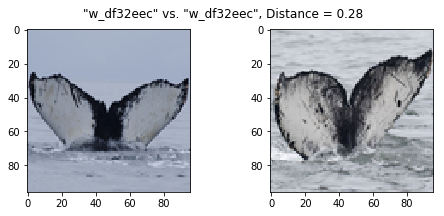

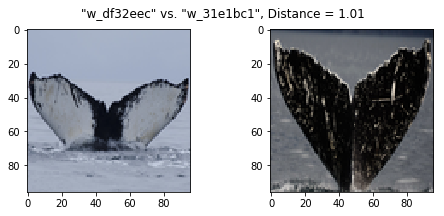

In [315]:
idx = 14631
print (metadata[idx].ID)
same = [i for i in range(len(metadata)) if metadata[i].ID == metadata[idx].ID]
print (same)
# for s in same:
#     print (distance(embedded[idx], embedded[s]))
not_same = [i for i in range(len(metadata)) if metadata[i].ID != metadata[idx].ID]
# print (not_same)
# for s in not_same:
#     print (distance(embedded[idx], embedded[s]))
show_pair(same[0], same[1])
show_pair(same[0], not_same[10])

In [316]:
distances = [] # squared L2 distance between pairs
identical = [] # 1 if same identity, 0 otherwise

num = len(metadata) // 10
print (num) # > 15k

for i in range(num - 1):
    update_progress(i/num)
    for j in range(1, num):
        distances.append(distance(embedded[i], embedded[j]))
        identical.append(1 if metadata_known[i].ID == metadata_known[j].ID else 0)
        
update_progress(1.0)
distances = np.array(distances)
identical = np.array(identical)

print(distances.shape)
print(identical.shape)

Progress: [===================>] 100.0%
(6426225,)
(6426225,)


In [317]:
from sklearn.metrics import f1_score, accuracy_score

thresholds = np.arange(0.01, 0.6, 0.01)

f1_scores = [f1_score(identical, distances < t) for t in thresholds]
acc_scores = [accuracy_score(identical, distances < t) for t in thresholds]

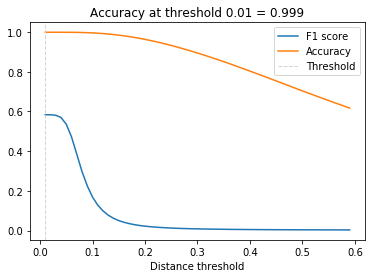

In [318]:
opt_idx = np.argmax(f1_scores)
# Threshold at maximal F1 score
opt_tau = thresholds[opt_idx]
# Accuracy at maximal F1 score
opt_acc = accuracy_score(identical, distances < opt_tau)

# Plot F1 score and accuracy as function of distance threshold
plt.plot(thresholds, f1_scores, label='F1 score');
plt.plot(thresholds, acc_scores, label='Accuracy');
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title('Accuracy at threshold {:.2f} = {:.3f}'.format(opt_tau, opt_acc));
plt.xlabel('Distance threshold')
plt.legend();

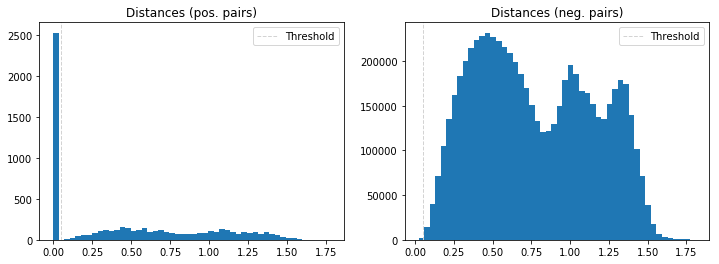

In [320]:
dist_pos = distances[identical == 1]
dist_neg = distances[identical == 0]
opt_tau = 0.05

plt.figure(figsize=(12,4))

plt.subplot(121)
plt.hist(dist_pos, bins=50)
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title('Distances (pos. pairs)')
plt.legend();

plt.subplot(122)
plt.hist(dist_neg, bins=50)
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title('Distances (neg. pairs)')
plt.legend();

In [321]:
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

targets = np.array([m.ID for m in metadata])

encoder = LabelEncoder()
encoder.fit(targets)

# Numerical encoding of identities
y = encoder.transform(targets)
train_idx = np.arange(len(metadata))

# train_idx = np.arange(len(metadata)) % 2 != 0
# test_idx = np.arange(len(metadata)) % 2 == 0

X_train = embedded[train_idx]
# X_test = embedded[test_idx]

# y_train = y[train_idx]
# y_test = y[test_idx]
y_train = targets

knn = KNeighborsClassifier(n_neighbors=10, metric='euclidean')
svc = LinearSVC()

knn.fit(X_train, y_train)
# svc.fit(X_train, y_train)

print ("KNN model was trained!")

# acc_knn = accuracy_score(y_test, knn.predict(X_test))
# acc_svc = accuracy_score(y_test, svc.predict(X_test))

# print('KNN accuracy = {}, SVM accuracy = {}'.format(acc_knn, acc_svc))

KNN model was trained!


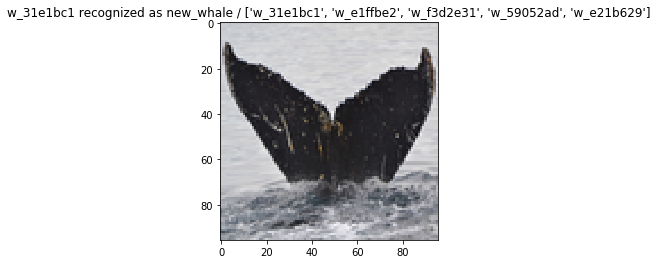

In [322]:
import warnings
# Suppress LabelEncoder warning
warnings.filterwarnings('ignore')

example_idx = 10

example_image = read_image(metadata[example_idx].image_path(), input_shape)
example_prediction = knn.predict([embedded[example_idx]])
dist, ind = knn.kneighbors([embedded[example_idx]])

pred = []; j = 0; n = 0; n_knn = 10
while n < 5:
    if j > n_knn-1:
        n_knn += 5
        dist, ind = knn.kneighbors([embedded[example_idx]], n_neighbors=n_knn)
    if not metadata[ind[0][j]].ID in pred:
        if n == 5 and dist[0][j] > 0.05 and not 'new_whale' in pred:
            pred += ['new_whale']
        else:
            pred += [metadata[ind[0][j]].ID]
        n += 1
            
    j += 1

# ind1 = [metadata[i].ID for i in ind[0]]
# print (dist[0], ind[0], ind1)
# j = 0
# for i in ind[0]:
#     print (dist[0][j], (distance(embedded[example_idx], embedded[i])))
#     j = j +1

plt.imshow(example_image)
plt.title('{} recognized as {} / {}'.format(metadata[example_idx].ID, example_identity, pred));


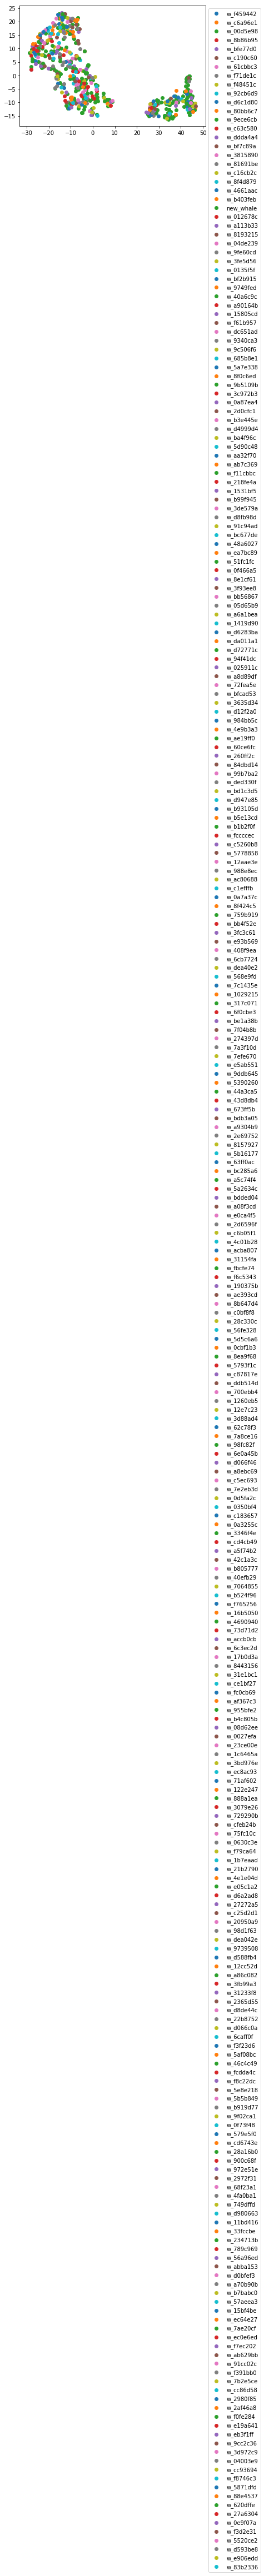

In [323]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(embedded[:500, :])

for i, t in enumerate(set(targets[:500])):
    idx = targets[:500] == t
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)   

plt.legend(bbox_to_anchor=(1, 1));

In [324]:
test_metadata = load_test_metadata('./')
n = len(test_metadata)
test_embedded = np.zeros((n, 128))


for i, m in enumerate(test_metadata):
    img = read_image(m.image_path(), input_shape)
    test_embedded[i] = nn4_small2.predict(np.expand_dims(img, axis=0))[0]
    update_progress(i/n)  
update_progress(1.0)

dist = np.zeros((n, 10))
indx = np.zeros((n, 10))

test_predictions = []

for i, emb in enumerate(test_embedded):
    update_progress(i/n)
    dist, ind = knn.kneighbors([emb])
    pred = []; j = 0; n = 0; n_knn = 10
    while n < 5:
        if j > n_knn-1:
            n_knn += 5
            dist, ind = knn.kneighbors([emb], n_neighbors=n_knn)
        if not metadata[ind[0][j]].ID in pred:
            if n == 5 and dist[0][j] > 0.05 and not 'new_whale' in pred:
                pred += ['new_whale']
            else:
                pred += [metadata[ind[0][j]].ID]
            n += 1

        j += 1
    test_predictions.append(pred)

update_progress(1.0)


Progress: [===================>] 100.0%


In [325]:
f= open("submission.csv","w+")
f.write("Image,Id\n")
delim = [' '] * 4 + ['\n']
for n, t in enumerate(test_predictions):
    p = test_metadata[n].file + ', '
    for i in range(5):
        p += t[i] + delim[i]
    f.write(p)
f.close()